In [27]:
import whisper
import sounddevice as sd
import soundfile as sf
import tempfile
import threading
import time
import pyttsx3
import cv2
import os
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets
import numpy as np
import time
from sklearn.metrics.pairwise import cosine_similarity
import threading
import cv2
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import mediapipe as mp
import time
import pygame

In [28]:
# -------- Configuration --------
MODEL_NAME = "medium.en"
RECORD_SECONDS = 4
SAMPLE_RATE = 16000
WAKE_PHRASES = ["guard my room", "guard my room please", "guard", "activate guard", "start guard"]
DISARM_PHRASES = ["stop guard", "disarm", "deactivate guard", "stop guard please", "stop"]

In [29]:
# Set default audio input device (change index if needed)
try:
    sd.default.device = sd.query_devices(kind='input')['name']
except Exception as e:
    print("[audio] Could not set default device:", e)

# persistent webcam
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("[webcam] ERROR: cannot open webcam")

def record_chunk(seconds=RECORD_SECONDS, samplerate=SAMPLE_RATE):
    print(f"[audio] recording {seconds}s...")
    try:
        recording = sd.rec(int(seconds * samplerate), samplerate=samplerate, channels=1)
        sd.wait()
    except Exception as e:
        print("[audio] ERROR:", e)
        return None
    tmp = tempfile.NamedTemporaryFile(suffix=".wav", delete=False)
    sf.write(tmp.name, recording, samplerate)
    return tmp.name

def contains_phrase(text, phrases):
    text = text.lower()
    return any(p in text for p in phrases)

def get_webcam_frame():
    ret, frame = cap.read()
    if not ret:
        return None
    return frame

out_widget = widgets.Output()
display(out_widget)
cap.release()


Output()

In [30]:
# def main():
#     global cap
#     cap = cv2.VideoCapture(0)
#     if not cap.isOpened():
#         print("[webcam] ERROR: cannot open webcam")
#         return

#     agent = GuardAgent()
#     print("Say a wake phrase (e.g., 'Guard my room') to activate. Say a disarm phrase to stop.")

#     try:
#         while True:
#             agent.listen_and_toggle()

#             if not agent.guard_mode:
#                 frame = get_webcam_frame()
#                 if frame is not None:
#                     _, encoded_img = cv2.imencode('.png', frame)
#                     img_bytes = encoded_img.tobytes()
#                     with out_widget:
#                         clear_output(wait=True)
#                         display(widgets.Image(value=img_bytes, format='png', width=640, height=480))
#             time.sleep(0.1)

#     except KeyboardInterrupt:
#         print("\n[exit] KeyboardInterrupt received — cleaning up.")
#     finally:
#         cap.release()
#         print("[exit] done.")

# main()

In [57]:
import mediapipe as mp
import cv2
import numpy as np
import os
from sklearn.metrics.pairwise import cosine_similarity

mp_face_mesh = mp.solutions.face_mesh

BASE_DIR = "enrolled_faces"
os.makedirs(BASE_DIR, exist_ok=True)


def extract_embedding(image_path):
    """Extract a 3D face landmark embedding from an image."""
    img = cv2.imread(image_path)
    if img is None:
        print("[enroll] Could not read image:", image_path)
        return None

    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True) as face_mesh:
        results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        if not results.multi_face_landmarks:
            print("[enroll] No face found in", image_path)
            return None
        landmarks = results.multi_face_landmarks[0].landmark
        emb = np.array([[lm.x, lm.y, lm.z] for lm in landmarks]).flatten()
        emb = emb / np.linalg.norm(emb)
        return emb

def enroll_face(person_name, image_paths):
    person_dir = os.path.join(BASE_DIR, person_name)
    os.makedirs(person_dir, exist_ok=True)

    for i, path in enumerate(image_paths):  # keep enumerate
        if not os.path.exists(path):
            print("[enroll] File not found:", path)
            continue
        emb = extract_embedding(path)
        if emb is not None:
            np.save(os.path.join(person_dir, f"{i}.npy"), emb)
            print(f"[enroll] Saved embedding {i+1} for {person_name}")
    print(f"[enroll] Completed enrollment for {person_name} ✅")



In [ ]:
enroll_face("Darshan", ["enrolled_faces/darshan1.jpg",room])
enroll_face("Vishal", ["enrolled_faces/vishal1.jpg", "enrolled_faces/vishal2.jpg"])

[enroll] Saved embedding 1 for Darshan
[enroll] Completed enrollment for Darshan ✅
[enroll] Saved embedding 1 for Vishal
[enroll] Saved embedding 2 for Vishal
[enroll] Completed enrollment for Vishal ✅


I0000 00:00:1759835699.670065       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4
I0000 00:00:1759835699.725885       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4
I0000 00:00:1759835699.795311       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4


In [88]:
def recognize_face_with_score(frame, threshold=0.75):
    """
    Recognize face from frame by comparing with all enrolled faces.
    Uses majority vote: counts embeddings exceeding threshold per person.
    Returns the person with the maximum count.
    """
    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True) as face_mesh:
        results = face_mesh.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        if not results.multi_face_landmarks:
            return "Unknown", frame, 0.0

        landmarks = results.multi_face_landmarks[0].landmark
        emb = np.array([[lm.x, lm.y, lm.z] for lm in landmarks]).flatten()
        emb = emb / np.linalg.norm(emb)

        best_name, best_count, best_sim = "Unknown", 0, 0.0

        for person_name in os.listdir(BASE_DIR):
            person_dir = os.path.join(BASE_DIR, person_name)
            if not os.path.isdir(person_dir):
                continue

            count_above_thresh = 0
            sims = []

            for f in os.listdir(person_dir):
                if not f.endswith(".npy"):
                    continue
                known_emb = np.load(os.path.join(person_dir, f))
                sim = cosine_similarity([emb], [known_emb])[0][0]
                sims.append(sim)
                if sim >= threshold:
                    count_above_thresh += 1

            # Majority vote
            if count_above_thresh > best_count:
                best_count = count_above_thresh
                best_name = person_name
                if sims:
                    best_sim = max(sims)

        # No one exceeded threshold
        if best_count == 0:
            best_name = "Unknown"
            best_sim = 0.0

        return best_name, frame, best_sim


In [85]:
import requests
from typing import Optional

try:
    from langchain_community.chat_models import ChatOllama
except Exception:
    ChatOllama = None  # type: ignore

from langchain.schema import HumanMessage, SystemMessage

_DEF_SYSTEM = "You are a polite, safety-focused guard assistant. Be brief and respectful."


def _probe_ollama(host: str = "http://localhost:11434", timeout: float = 0.75) -> bool:
    try:
        requests.get(f"{host}/api/tags", timeout=timeout)
        return True
    except Exception:
        return False


def _get_llm() -> Optional["ChatOllama"]:
    if ChatOllama is None:
        return None
    if not _probe_ollama():
        print("[dialogue] Ollama server not available at localhost:11434 — using offline fallback replies.")
        return None
    try:
        return ChatOllama(model="llama3")  # or another local model you've pulled
    except Exception:
        print("[dialogue] Could not initialize ChatOllama — using offline fallback replies.")
        return None


_LLM = _get_llm()


def _fallback_reply(prompt: str) -> str:
    p = prompt.lower()
    if "who are you" in p or "identify" in p:
        return "I am a home security assistant. Please identify yourself."
    if "ask them to leave" in p or "please leave" in p:
        return "Please step away from the door. This area is restricted."
    if "stern" in p or "alarm" in p or "intruder" in p:
        return "Warning. Security protocol active. Leave the area immediately."
    return "Please state your purpose. This area is monitored."


def generate_dialogue(prompt: str) -> str:
    if _LLM is None:
        return _fallback_reply(prompt)
    messages = [
        SystemMessage(content=_DEF_SYSTEM),
        HumanMessage(content=prompt),
    ]
    try:
        response = _LLM.invoke(messages)
        return getattr(response, "content", "") or _fallback_reply(prompt)
    except Exception:
        return _fallback_reply(prompt)



In [ ]:
class GuardAgent:
    def __init__(self, cap):
        print("[init] loading Whisper model:", MODEL_NAME)
        self.model = whisper.load_model(MODEL_NAME)
        self.tts = pyttsx3.init()
        self.tts.setProperty("rate", 150)
        self.tts.setProperty("volume", 1.0)
        self.guard_mode = False
        self.cap = cap
        self.last_name = None
        self.last_detect_time = 0
        self.guard_thread = None
        self.guard_stop_event = threading.Event()
        self.intruder_levels = {}
        self.level_timers = {}
        pygame.mixer.init()
        self.alarm_file = "alarm.mp3"
        self.alarm_playing = False

    def run_guard_mode(self):
        print("[guard] Running face detection...")
        mp_face = mp.solutions.face_detection
        plt.ion()
        fig, ax = plt.subplots()

        with mp_face.FaceDetection(model_selection=0, min_detection_confidence=0.5) as detector:
            while self.guard_mode and not self.guard_stop_event.is_set():
                ret, frame = self.cap.read()
                if not ret:
                    break

                rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                results = detector.process(rgb)
                intruder_present = False

                if results.detections:
                    for det in results.detections:
                        bboxC = det.location_data.relative_bounding_box
                        ih, iw, _ = frame.shape
                        x1 = int(bboxC.xmin * iw)
                        y1 = int(bboxC.ymin * ih)
                        w = int(bboxC.width * iw)
                        h = int(bboxC.height * ih)
                        x2, y2 = x1 + w, y1 + h

                        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                        face_crop = frame[max(0, y1):min(ih, y2), max(0, x1):min(iw, x2)]
                        name = "Unknown"

                        if face_crop.size > 0:
                            name, _, _ = recognize_face_with_score(face_crop)

                            # Welcome known person
                            if name != "Unknown" and name != self.last_name:
                                if time.time() - self.last_detect_time > 5:
                                    self.tts.say(f"Welcome back, {name}.")
                                    self.tts.runAndWait()
                                    self.last_name = name
                                    self.last_detect_time = time.time()

                            # Handle unknown intruder
                            if name == "Unknown":
                                intruder_present = True
                                level = self.intruder_levels.get(name, 1)
                                last_time = self.level_timers.get(name, 0)

                                # Escalate every 10 seconds
                                if time.time() - last_time > 10:
                                    if level == 1:
                                        prompt = "Unknown person detected. Who are you?"
                                        reply = generate_dialogue(prompt)
                                        self.tts.say(reply)
                                        self.tts.runAndWait()
                                    elif level == 2:
                                        prompt = "Unknown person still present. Please leave immediately."
                                        reply = generate_dialogue(prompt)
                                        self.tts.say(reply)
                                        self.tts.runAndWait()
                                    elif level == 3:
                                        prompt = "Intruder ignoring warnings. Final stern warning."
                                        reply = generate_dialogue(prompt)
                                        self.tts.say(reply)
                                        self.tts.runAndWait()

                                        # Play alarm
                                        if os.path.exists(self.alarm_file) and not self.alarm_playing:
                                            pygame.mixer.music.load(self.alarm_file)
                                            pygame.mixer.music.play(-1)
                                            self.alarm_playing = True
                                    else:
                                        # Level 4+ continuous alarm + escalate
                                        prompt = "Intruder persists. Security authorities will be notified."
                                        reply = generate_dialogue(prompt)
                                        self.tts.say(reply)
                                        self.tts.runAndWait()
                                        if os.path.exists(self.alarm_file) and not self.alarm_playing:
                                            pygame.mixer.music.load(self.alarm_file)
                                            pygame.mixer.music.play(-1)
                                            self.alarm_playing = True

                                    # Update level and timer
                                    self.intruder_levels[name] = level + 1
                                    self.level_timers[name] = time.time()

                        cv2.putText(frame, f"{name}", (x1, y2 + 30),
                                    cv2.FONT_HERSHEY_SIMPLEX, 1.0,
                                    (0, 255, 0) if name != "Unknown" else (0, 0, 255), 2)

                if not intruder_present and self.alarm_playing:
                    pygame.mixer.music.stop()
                    self.alarm_playing = False

                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                ax.clear()
                ax.imshow(frame_rgb)
                ax.axis('off')
                clear_output(wait=True)
                display(fig)
                plt.pause(0.01)

        plt.close(fig)


[exit] done.


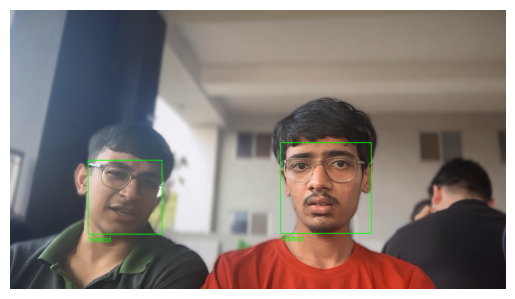

In [ ]:
# def main():
#     cap = cv2.VideoCapture(0)
#     if not cap.isOpened():
#         print("[webcam] cannot open webcam")
#         return
#     agent = GuardAgent(cap)
#     print("Say 'guard my room' to activate. Say 'stop guard' to stop.")

#     try:
#         while True:
#             agent.listen_and_toggle()
#             # Optional: show webcam preview when not in guard mode
#             if not agent.guard_mode:
#                 frame = get_webcam_frame()
#                 if frame is not None:
#                     _, encoded_img = cv2.imencode('.png', frame)
#                     img_bytes = encoded_img.tobytes()
#                     with out_widget:
#                         clear_output(wait=True)
#                         display(widgets.Image(value=img_bytes, format='png', width=640, height=480))
#             time.sleep(0.1)
#     except KeyboardInterrupt:
#         print("\n[exit] KeyboardInterrupt received — cleaning up.")
#     finally:
#         if hasattr(agent, 'alarm_playing') and agent.alarm_playing:
#             pygame.mixer.music.stop()
#             agent.alarm_playing = False
#         cap.release()
#         print("[exit] done.")

# main()

def main():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("[webcam] cannot open webcam")
        return

    agent = GuardAgent(cap)

    # Force guard mode ON immediately
    agent.guard_mode = True
    agent.guard_stop_event.clear()
    agent.guard_thread = threading.Thread(target=agent.run_guard_mode, daemon=True)
    agent.guard_thread.start()

    print("[init] Guard mode activated automatically.")
    print("Say 'stop guard' to stop.")

    try:
        while True:
            # Skip listen_and_toggle() since guard is always ON
            # agent.listen_and_toggle()

            # Optional: show webcam preview when not in guard mode
            if not agent.guard_mode:
                frame = get_webcam_frame()
                if frame is not None:
                    _, encoded_img = cv2.imencode('.png', frame)
                    img_bytes = encoded_img.tobytes()
                    with out_widget:
                        clear_output(wait=True)
                        display(widgets.Image(value=img_bytes, format='png', width=640, height=480))

            time.sleep(0.1)
    except KeyboardInterrupt:
        print("\n[exit] KeyboardInterrupt received — cleaning up.")
    finally:
        if hasattr(agent, 'alarm_playing') and agent.alarm_playing:
            pygame.mixer.music.stop()
            agent.alarm_playing = False
        cap.release()
        print("[exit] done.")

main()

